In [1]:
import torch
from models import simplecnn
from dataset import get_spurious_samples, make_dataloaders
from easydict import EasyDict  as edict
from torchvision.transforms import ToTensor, Normalize, Compose
from collections import defaultdict
from train import get_gradients_from_data
from copy import deepcopy


def mean_accuracy(logits, y):
    preds = (logits.squeeze() > 0.).float()
    return  ((preds - y).abs() < 1e-2).float().mean()

task_args = edict()
args = edict()
args.eval_datasets = dict()
task_args.mode = ["task"
                   #, 'play'
                  # ,'forget'
                   ]
args.dataset_paths = {'synmnist': "../datasets/SynMNIST"}
task_args.dataset = {'name': 'synmnist', 'p': 0.875 ,
                     'bg': 'nobg',
                     'splits': ['train','val'],
                     'baseline': False, 'bs': 16000}
args.model='scnn'
for k,v in task_args.items():
    args['task_'+k] = v
    
args.task_args = task_args

dls = make_dataloaders(args)

x = defaultdict(list)
y = defaultdict(list)

for split in ['train', 'val']:
    for xs,ys  in dls['task'][split]:
        x[split].append(xs)
        y[split].append(ys)
        
    x[split] = torch.cat(x[split])
    y[split] = torch.cat(y[split])


# Cargar modelo preentrenado
ruta = "models/scnn_synmnist_0.875_nobg_nobs_nofrz_1001_cmnist_baseline.pth"
ruta = "models/scnn_synmnist_0.875_nobg_nobs_nofrz_101_cmnist_baseline.pth"
weights = torch.load(ruta)
old_weights = weights

model = simplecnn(args)
model.load_state_dict(weights)
model = model

# Registrar hook para obtener valores intermedios
def hook_fn(module, input, output):
    model.output = output

#print(dir(model))
model.features.flatten.register_forward_hook(hook_fn)
# Crear datos espurios vs datos no espurios
spur_data, non_spur_data, y_spur = get_spurious_samples()

spur_data = spur_data.cpu()
non_spur_data = non_spur_data.cpu()
y_spur = y_spur.cpu()


input_for_mask = []
spur_grads_red = get_gradients_from_data(model, spur_data[:30000], y_spur[:30000])
input_for_mask.append(deepcopy(spur_grads_red))
non_spur_grads_red = get_gradients_from_data(model, non_spur_data[:30000], y_spur[:30000])
input_for_mask.append(deepcopy(non_spur_grads_red))
spur_grads_green = get_gradients_from_data(model, spur_data[30000:], y_spur[30000:])
input_for_mask.append(deepcopy(spur_grads_green))
non_spur_grads_green = get_gradients_from_data(model, non_spur_data[30000:], y_spur[30000:])
input_for_mask.append(deepcopy(non_spur_grads_green))
#input_for_mask = [spur_grads_red, non_spur_grads_red,spur_grads_green, non_spur_grads_green]



Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.
Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.


AttributeError: 'EasyDict' object has no attribute 'output_dims'

In [44]:
from torch.linalg import matrix_rank, svd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# for each model

def calculate_result(model, ruta, iterations,least=True):
    weights = torch.load(ruta)
    old_weights = weights
    split_accs = dict()
    model.load_state_dict(weights)

    for split in ['train','val']:
        logits = model(x[split])
        split_accs[split] = mean_accuracy(logits, y[split])
    
    # calculate representations
    model(x['train'])
    reps_train = model.output.clone().detach()
    model(x['val'])
    reps_val = model.output.clone().detach()
    # Get train eigenvectors
    reps_val -= reps_train.mean(dim=0)
    U, S, V = torch.pca_lowrank(reps_train, center=True, q=1000)
    y_test = y['val']

    accs = defaultdict(list)

    for k in tqdm(iterations):
        V_selected = V[:,:k] if least else V[:,k:]
        with torch.no_grad():
            p_inv = torch.linalg.pinv(V_selected)                # Calculate pseudoinverse...

            logits_train = torch.matmul(reps_train, V_selected)  # Project to k more important directions
            logits_train = torch.matmul(logits_train, p_inv)  # Come back to original space via pseudoinverse
            logits_train += reps_train.mean(dim=0)            # Add back the mean from training data to predict
            logits_train = model.fc(logits_train)             # Pass through classifier for result

            accs['train'].append(mean_accuracy(logits_train,y['train']))

            logits_val = torch.matmul(reps_val, V_selected)      # Project to k more important directions
            logits_val = torch.matmul(logits_val, p_inv)      # Come back to original space via pseudoinverse
            logits_val += reps_train.mean(dim=0)              # Add back the mean from training data to predict
            logits_val = model.fc(logits_val)                 # Pass through classifier for result

            accs['val'].append(mean_accuracy(logits_val,y['val']))
    return accs, split_accs

def create_results_plot(results, accuracies,  caption="Acc (%) vs losing Top K directions"):
    
    def create_plot(ax, p, accs, split_accs, iterations):
        ax.set_title(f"P = {p} - {caption}")
        ax.plot(iterations, accs['train'][:n], label='train data', color='red')
        ax.plot(iterations, accs['val'][:n], label='val data', color='blue')
        ax.axhline(y=split_accs['val'], color='blue', linestyle='--', label="full val")
        ax.axhline(y=split_accs['train'], color='red', linestyle='--', label='full train')
        ax.legend()
    
    fig, axs = plt.subplots(nrows=len(results), ncols=2)
    fig.set_size_inches(16, len(results)*5)

    for i, (p, accs) in enumerate(results.items()):
        ruta = p
        p = p.split("_")[2]
        n = 7
        create_plot(axs[i, 0], p, accs, accuracies[ruta], iterations[:n])
        create_plot(axs[i, 1], p, accs, accuracies[ruta], iterations[:n])


In [6]:
from train import evaluate
# Load dataset 0.0
from dataset import get_spurious_samples, make_dataloaders
from easydict import EasyDict  as edict
from models import simplecnn
import torch
from collections import defaultdict


corrs = [0.5, 0.625, 0.75, 0.875, 0.95, 1]

split = 'val'
for corr in corrs:
    
    task_args = edict()
    args = edict()
    args.eval_datasets = dict()
    task_args.mode = ["task"
                       #, 'play'
                      # ,'forget'
                       ]
    args.dataset_paths = {'synmnist': "SynMNIST"}
    task_args.dataset = {'name': 'synmnist', 'p': 0.5 ,
                     'bg': 'nobg',
                     'splits': ['train','val'],
                     'baseline': False, 'bs': 16000}
    args.model='scnn'
    for k,v in task_args.items():
        args['task_'+k] = v

    args.task_args = task_args

    dls = make_dataloaders(args)

    x = defaultdict(list)
    y = defaultdict(list)

    for xs,ys  in dls['task'][split]:
        x[split].append(xs)
        y[split].append(ys)

    x[split] = torch.cat(x[split])
    y[split] = torch.cat(y[split])
    
    for m in corrs:
        # Cargar modelo preentrenado
        ruta = f"models/scnn_synmnist_{m}_nobg_nobs_cmnist_baseline.pth"
        weights = torch.load(ruta)

        model = simplecnn(args)
        model = model.cuda()
        model.eval()
        model.load_state_dict(weights)
        # Evaluate model in dataset
        acc = evaluate(model, dls['task']['val'], show=False, caption='val')
        print(corr, m, acc['val_acc'])


Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.
Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.
0.5 0.5 91.94500732421875
0.5 0.625 90.46501159667969
0.5 0.75 87.05001068115234
0.5 0.875 77.7300033569336
0.5 0.95 68.38500213623047
0.5 1 50.280006408691406
Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.
Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.
0.625 0.5 91.94499969482422
0.625 0.625 90.46501159667969
0.625 0.75 87.04999542236328
0.625 0.875 77.7300033569336
0.625 0.95 68.38500213623047
0.625 1 50.280006408691406
Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.
Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.
0.75 0.5 91.94499969482422
0.75 0.625 90.46499633789062
0.75 0.75 87.04999542236328
0.75 0.875 77.7300033569336
0.75 0.95 68.385002136

In [ ]:
%%time

r = dict()
a = dict()
iterations = [0,1,2,3,4,5,10,50,100,250,500,1000]
for bg in ['nobg','gradient','images']:
    results = dict()
    accuracies = dict()

    x = defaultdict(list)
    y = defaultdict(list)

    for split in ['train', 'val']:
        for xs,ys  in dls['task'][split]:
            x[split].append(xs)
            y[split].append(ys)

        x[split] = torch.cat(x[split])
        y[split] = torch.cat(y[split])
        

    rutas = [
        f"models/scnn_synmnist_0.5_{bg}_nobs_cmnist_baseline.pth",
        f"models/scnn_synmnist_0.625_{bg}_nobs_cmnist_baseline.pth",
        f"models/scnn_synmnist_0.75_{bg}_nobs_cmnist_baseline.pth",
        f"models/scnn_synmnist_0.875_{bg}_nobs_cmnist_baseline.pth",
        f"models/scnn_synmnist_0.95_{bg}_nobs_cmnist_baseline.pth",
        f"models/scnn_synmnist_1_{bg}_nobs_cmnist_baseline.pth"
    ]
    for ruta in tqdm(rutas):
        accs, split_accs = calculate_result(model, ruta, iterations, least=False)
        results[ruta] = accs
        accuracies[ruta] = split_accs
    r[bg] = results
    a[bg] = accuracies

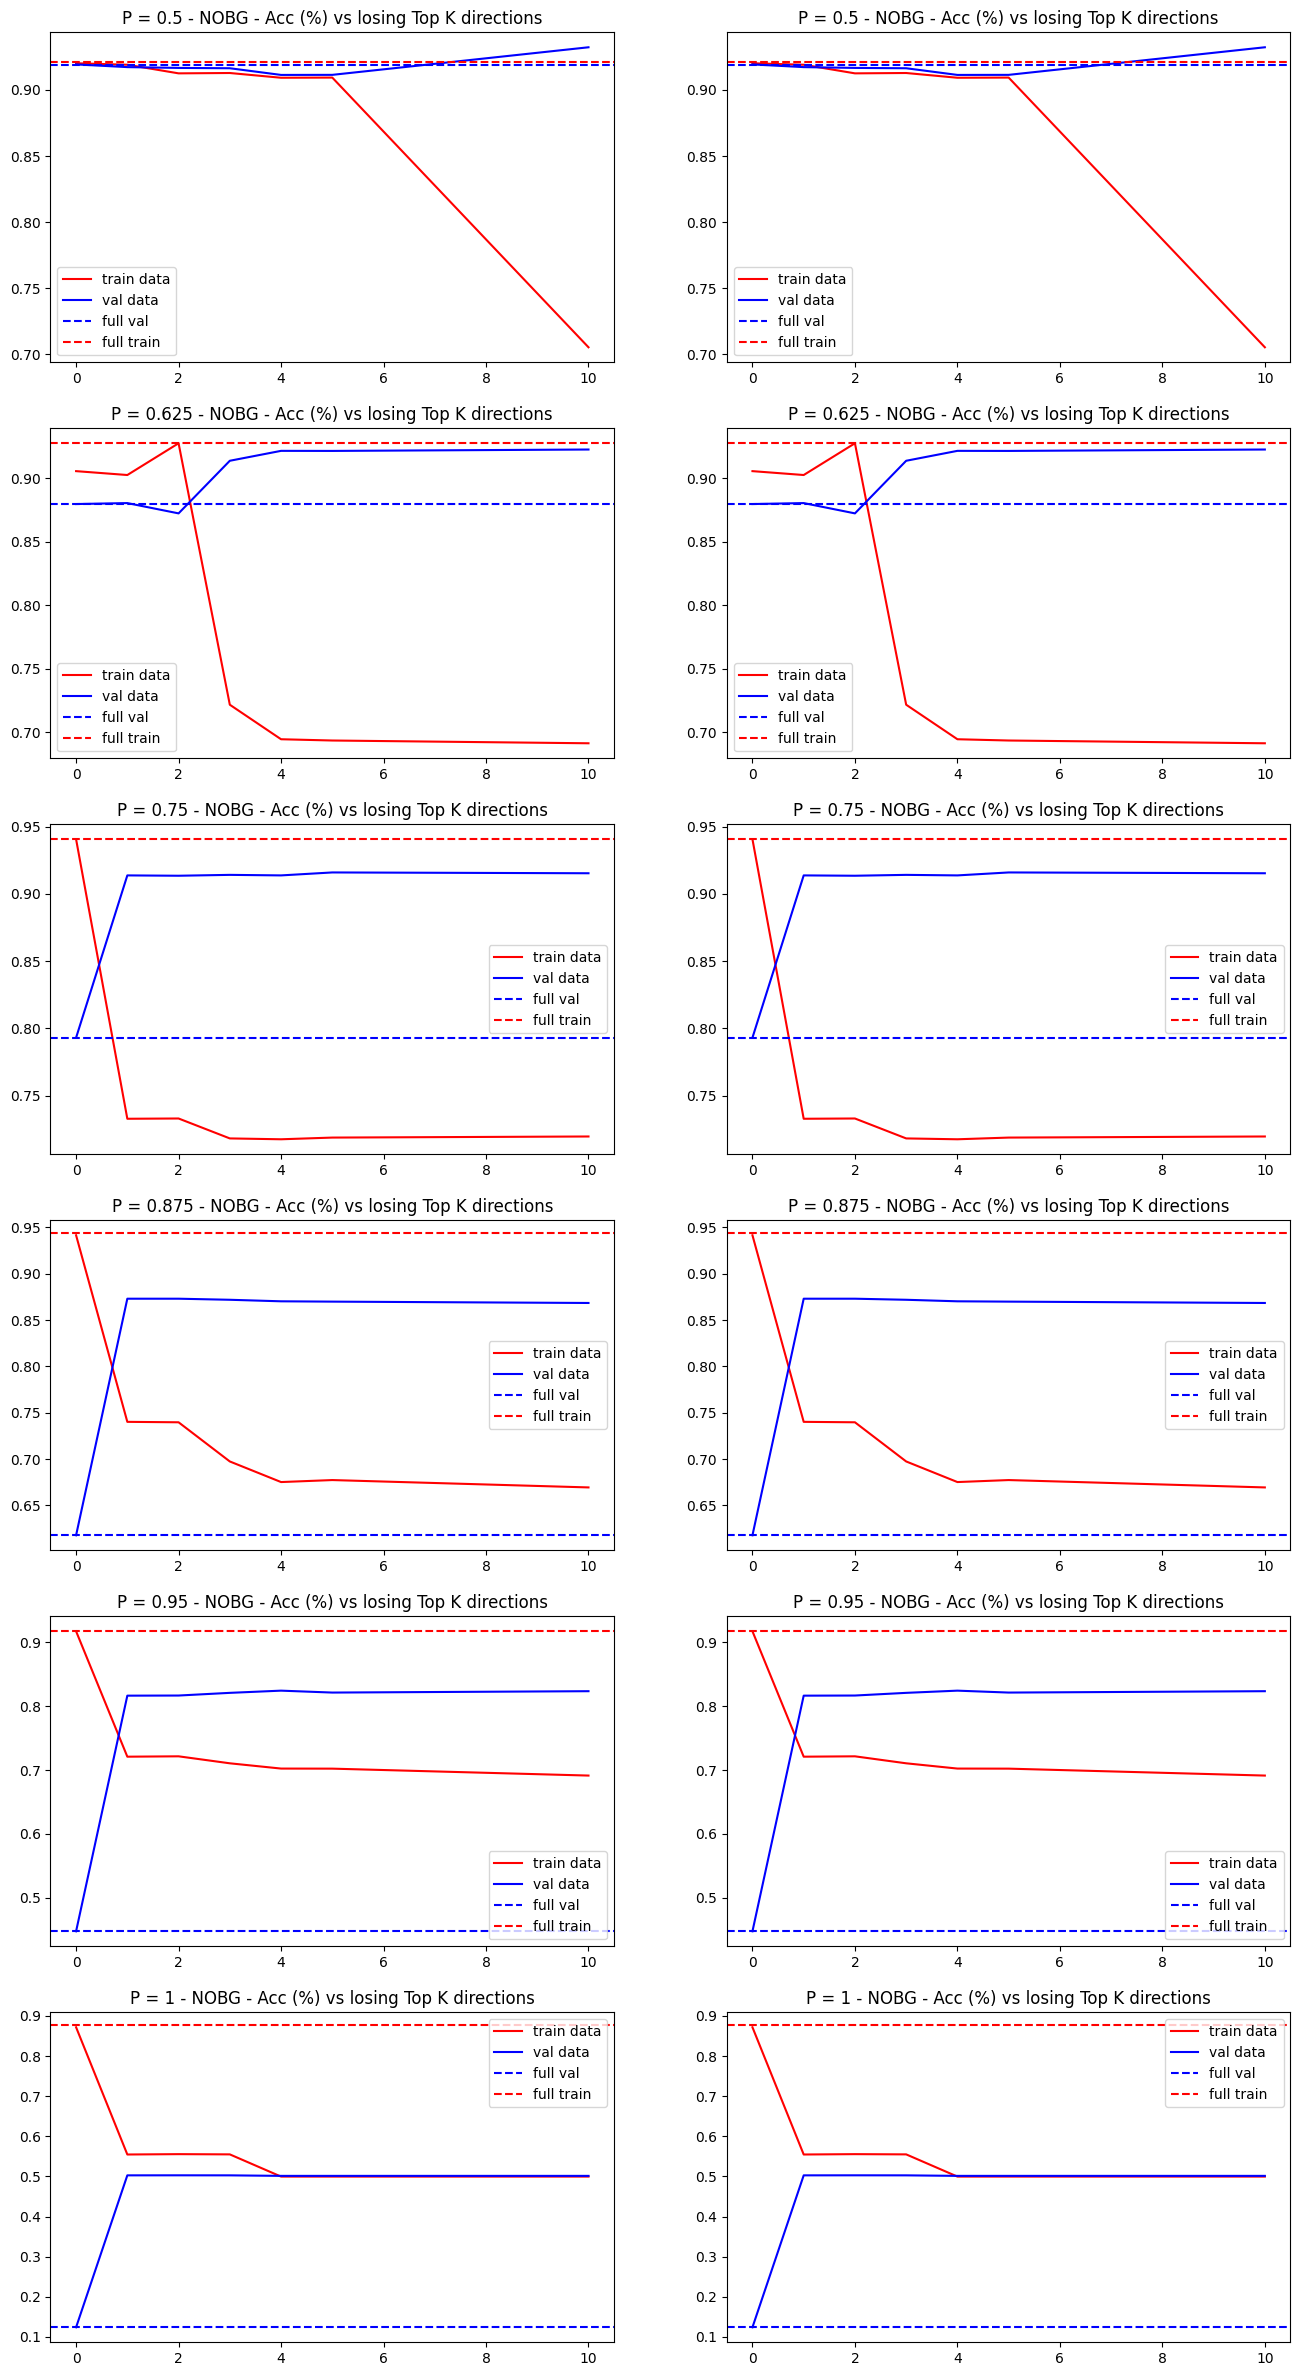

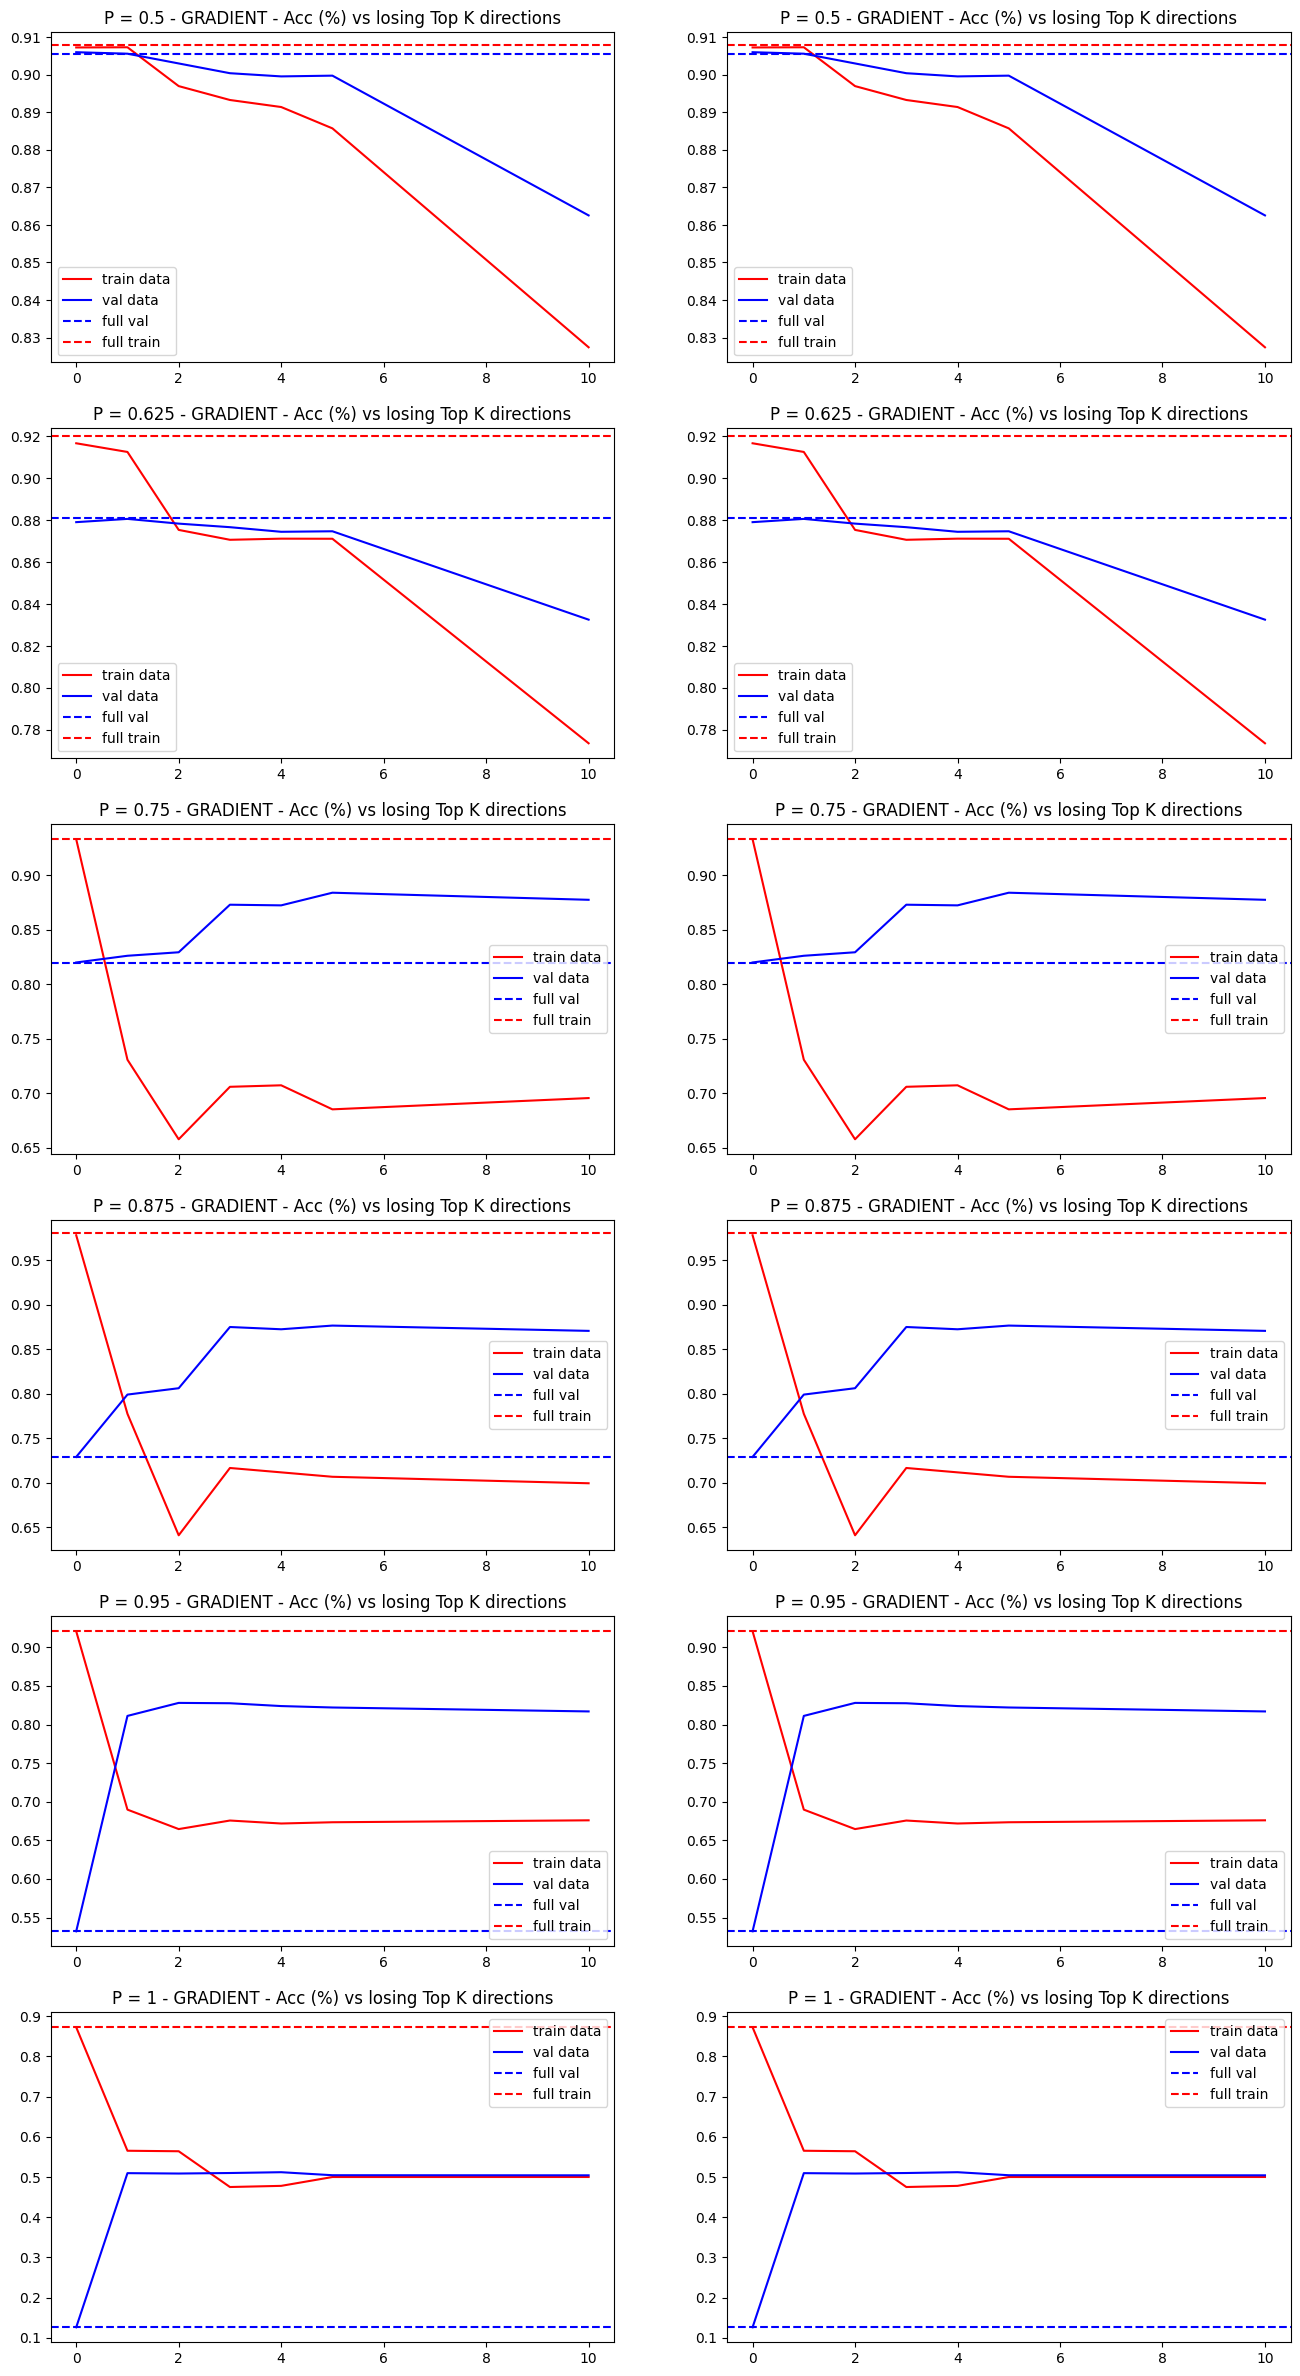

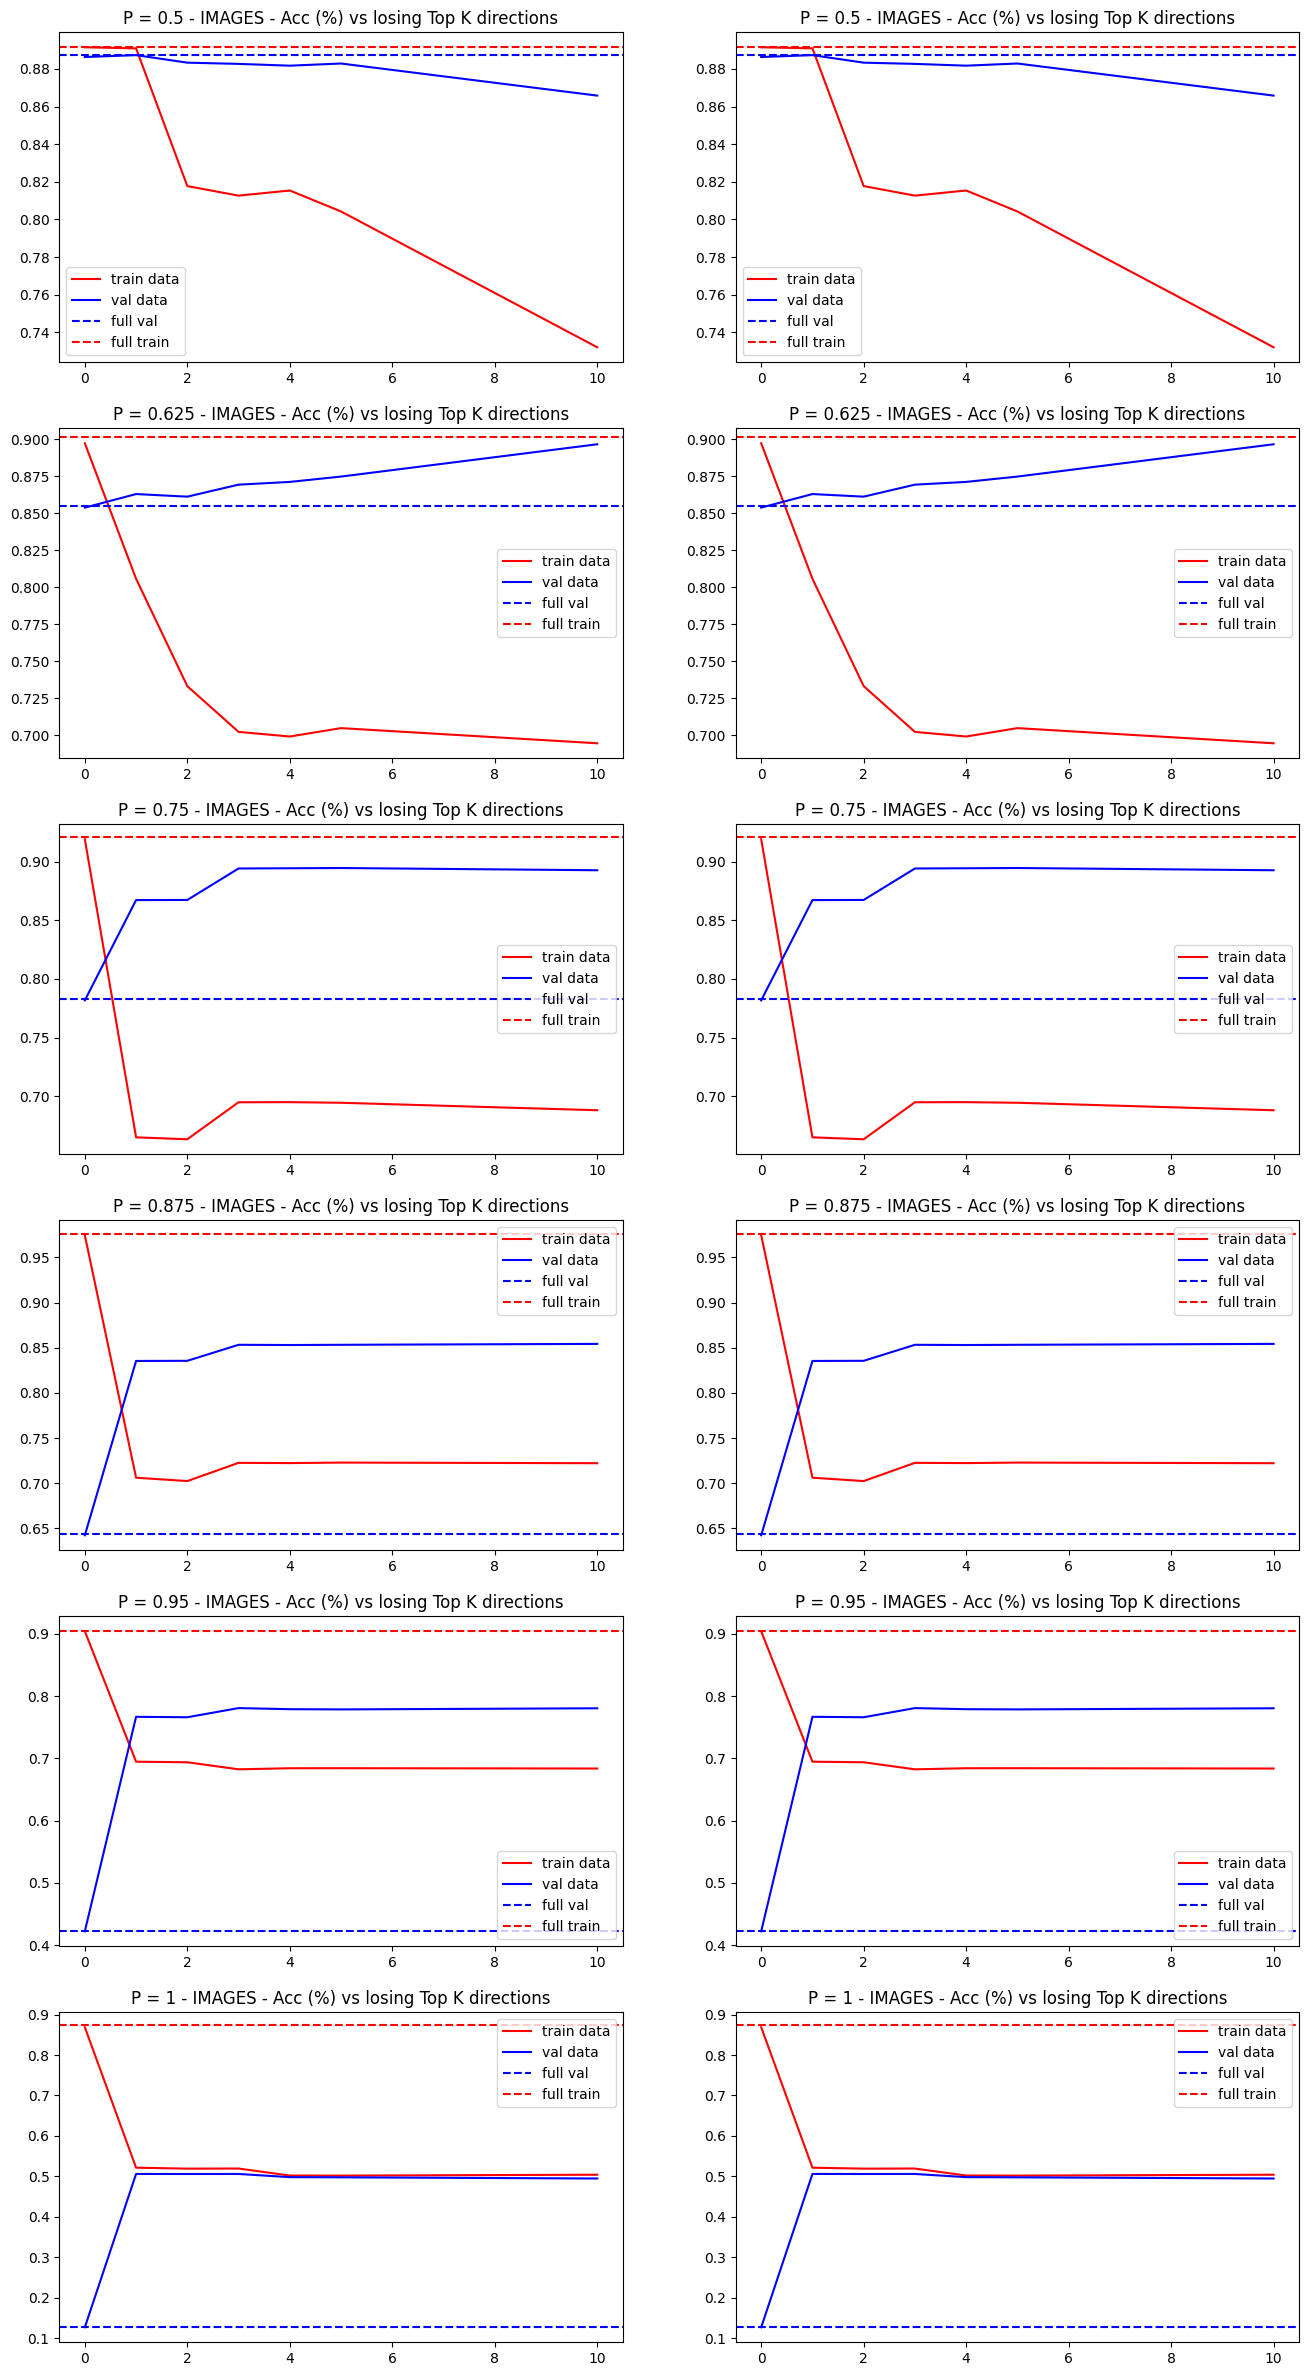

In [27]:
for bg in ['nobg','gradient','images']:
    create_results_plot(r[bg], a[bg], caption=f"{bg.upper()} - Acc (%) vs losing Top K directions")
   

In [49]:
import numpy as np
import pandas as pd
df = pd.DataFrame(columns=['Background', 'Corr', 'K', 'Max_Value', 'Mean_Val_Acc'])

for bg in ['nobg','gradient','images']:
    rutas = [
        f"models/scnn_synmnist_0.5_{bg}_nobs_cmnist_baseline.pth",
        f"models/scnn_synmnist_0.625_{bg}_nobs_cmnist_baseline.pth",
        f"models/scnn_synmnist_0.75_{bg}_nobs_cmnist_baseline.pth",
        f"models/scnn_synmnist_0.875_{bg}_nobs_cmnist_baseline.pth",
        f"models/scnn_synmnist_0.95_{bg}_nobs_cmnist_baseline.pth",
        f"models/scnn_synmnist_1_{bg}_nobs_cmnist_baseline.pth"
    ]
    for ruta in rutas:
        mean_tr_acc = a[bg][ruta]['train']
        mean_val_acc = a[bg][ruta]['val']
        val_values = np.array(r[bg][ruta]['val'])
        train_values = np.array(r[bg][ruta]['train'])
        new_values = np.minimum(train_values, val_values)
        max_index = np.argmax(new_values)
        max_value = np.max(new_values)
        # Create a new row and append it to the DataFrame
        new_row = pd.DataFrame({
            'Background': [bg],
            'Corr': [str(round(float(ruta.split("_")[2])*2-1, 2))],
            'K': [max_index],
            'Max_Value': [max_value],
            'Mean_Val_Acc': [float(mean_val_acc)]
        })
        df = pd.concat([df, new_row], ignore_index=True)
        
print(df)

   Background  Corr  K  Max_Value  Mean_Val_Acc
0        nobg   0.0  0   0.919200       0.91850
1        nobg  0.25  1   0.880400       0.87965
2        nobg   0.5  0   0.793050       0.79305
3        nobg  0.75  1   0.740188       0.61785
4        nobg   0.9  2   0.721462       0.44720
5        nobg   1.0  2   0.502700       0.12395
6    gradient   0.0  0   0.906050       0.90570
7    gradient  0.25  1   0.880600       0.88105
8    gradient   0.5  0   0.819900       0.81975
9    gradient  0.75  1   0.777400       0.72860
10   gradient   0.9  1   0.689750       0.53245
11   gradient   1.0  1   0.509500       0.12620
12     images   0.0  1   0.887300       0.88760
13     images  0.25  0   0.853800       0.85505
14     images   0.5  0   0.781700       0.78290
15     images  0.75  5   0.722713       0.64360
16     images   0.9  1   0.694575       0.42205
17     images   1.0  1   0.505800       0.12645


## Histogram of values for train and val data

p = 0.875

In [3]:
from collections import defaultdict
bg = 'nobg'

ruta = f"models/scnn_synmnist_0.875_{bg}_nobs_cmnist_baseline.pth"

# Get dataloaders
task_args.dataset = {'name': 'synmnist', 'p': 0.875 ,
                 'bg': bg,
                 'splits': ['train','val','test'],
                 'baseline': False, 'bs': 16000}
for k,v in task_args.items():
    args['task_bg'] = bg

args.task_args = task_args

dls = make_dataloaders(args)
x = defaultdict(list)
y = defaultdict(list)

for split in ['train', 'val','test']:
    for xs,ys  in dls['task'][split]:
        x[split].append(xs)
        y[split].append(ys)

    x[split] = torch.cat(x[split])
    y[split] = torch.cat(y[split])


Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.
Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.
Loading hdf5...
Converting json strings to labels...
Done converting.
Done reading hdf5.


In [6]:

# Load model to evaluate
weights = torch.load(ruta)
model.load_state_dict(weights)
# calculate representations
def get_representations(model, x):
    rs = dict()
    model(x['train'])
    rs['train'] = model.output.clone().detach()
    reps_mean = rs['train'].mean(dim=0).clone()
    rs['train'] -= reps_mean
    model(x['val'])
    rs['val'] = model.output.clone().detach()
    rs['val'] -= reps_mean
    model(x['test'])
    rs['test'] = model.output.clone().detach()
    rs['test'] -= reps_mean
    return rs

def split_representations(rs):
    reps = defaultdict(dict)
    indices = defaultdict(dict)

    for split in ['train','val','test']:
        for c in [0,1]:
            reps[split][c] = rs[split][y[split] == c]
            indices[split][c] = torch.where((y[split] == c) > 0)[0]
    return reps, indices

def get_logits(reps, V):
    logits = defaultdict(dict)
    with torch.no_grad():
        for split in ['train','val']:
            for c in [0,1]:
                logits[split][c] = torch.matmul(reps[split][c], V)  # Project to k most important directions
    return logits
rs = get_representations(model, x)
reps, indices = split_representations(rs)



In [8]:
# Get train eigenvectors
U, S, V = torch.pca_lowrank(rs['train'], center=True, q=1000)
y_test = y['val']
logits = get_logits(reps, V)

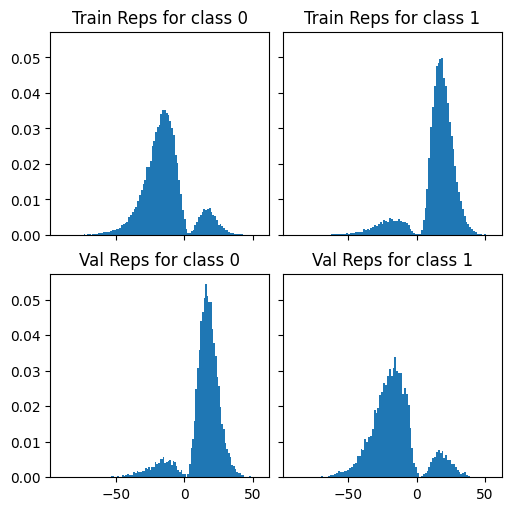

In [11]:
bins = 100
k=0
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,constrained_layout=True)
fig.set_size_inches(5,5)

for i, split in enumerate(['train','val']):
    for c in [0,1]:
        axs[i,c].hist(logits[split][c][:,k], bins, density=True)
        axs[i,c].set_title(f"{split.capitalize()} Reps for class {c}")

In [4]:
from torchvision.transforms import Normalize

def plot_images_grid(images, num_images):
    # Generate random indices to select images
    indices = np.random.choice(images.shape[0], num_images, replace=False)

    # Select the images using the indices
    selected_images = images[indices]

    # Create a square grid for plotting
    grid_size = int(np.ceil(np.sqrt(num_images)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))

    # Plot the images on the grid
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            image = selected_images[i].numpy().transpose(1, 2, 0)
            ax.imshow(image)
            ax.axis('off')
        else:
            ax.axis('off')

    # Adjust spacing and display the plot
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    return fig



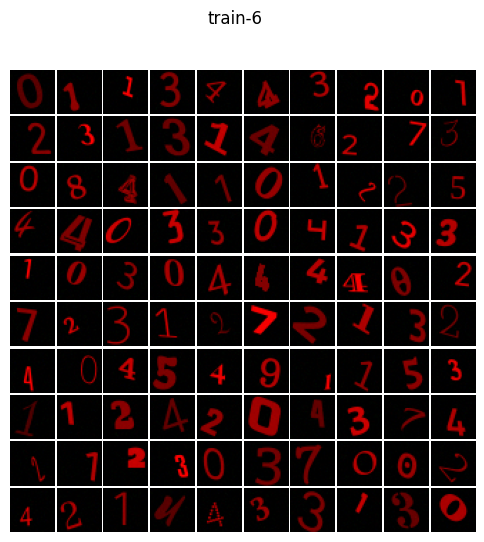

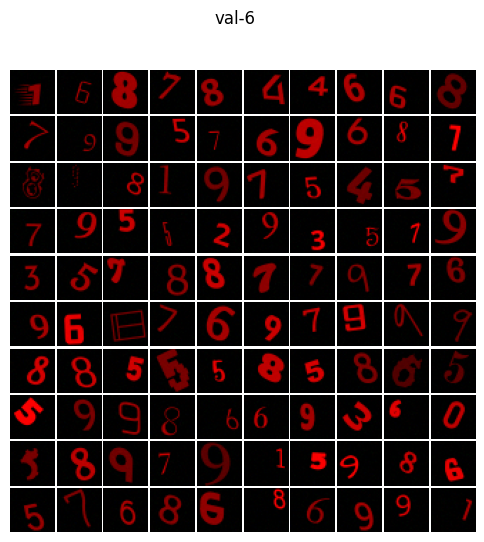

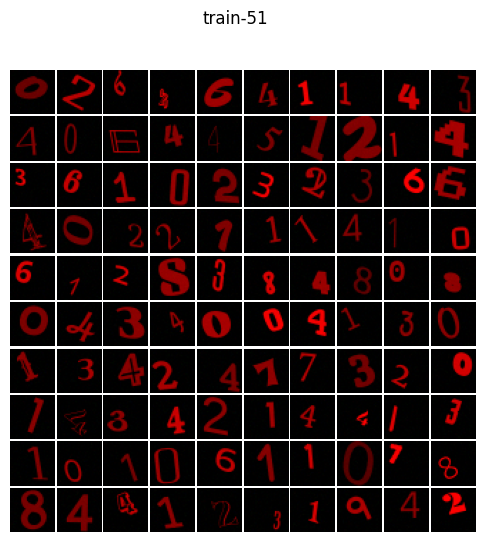

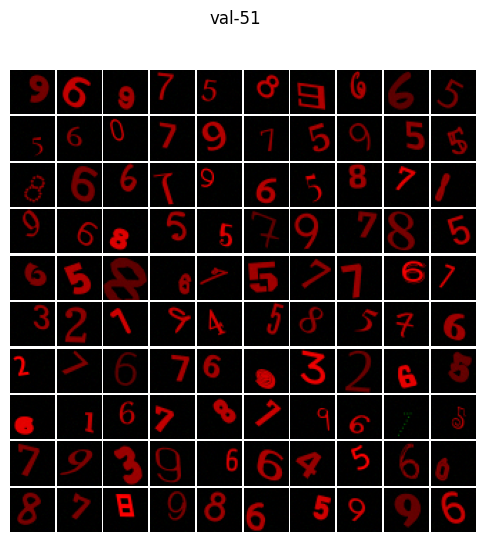

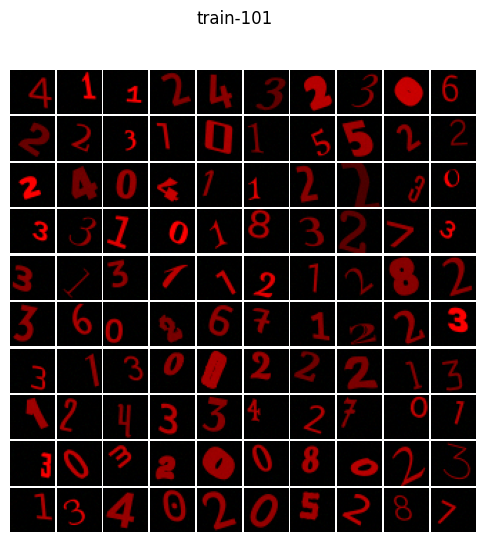

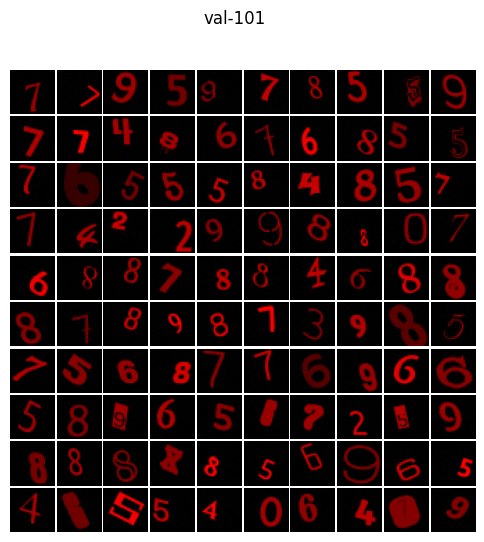

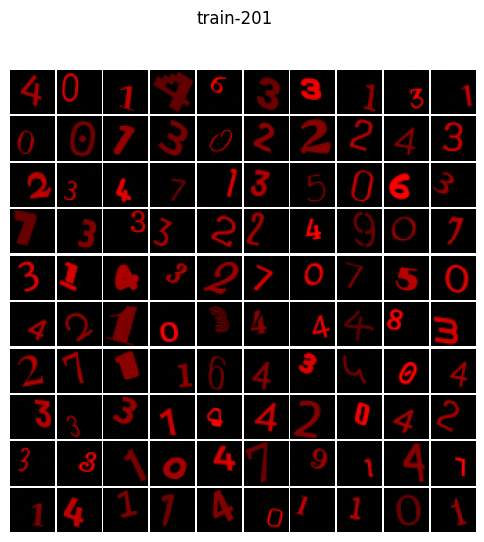

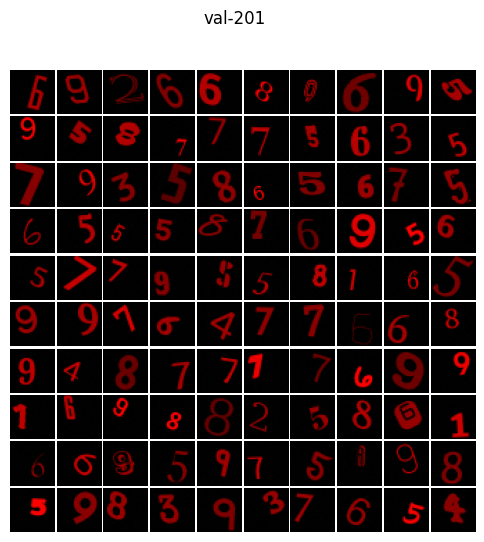

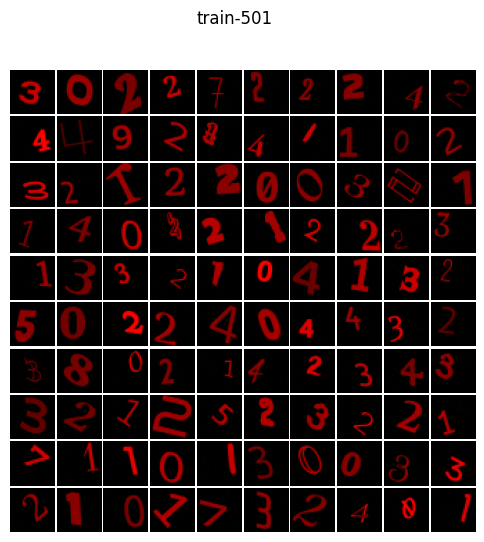

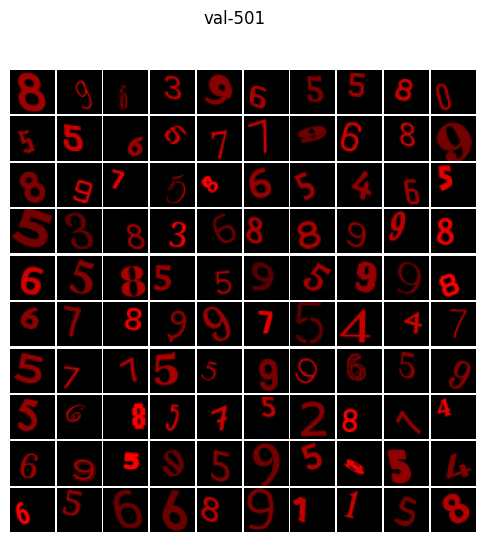

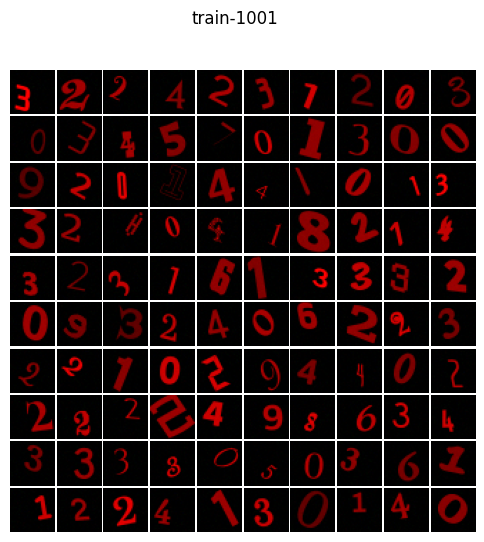

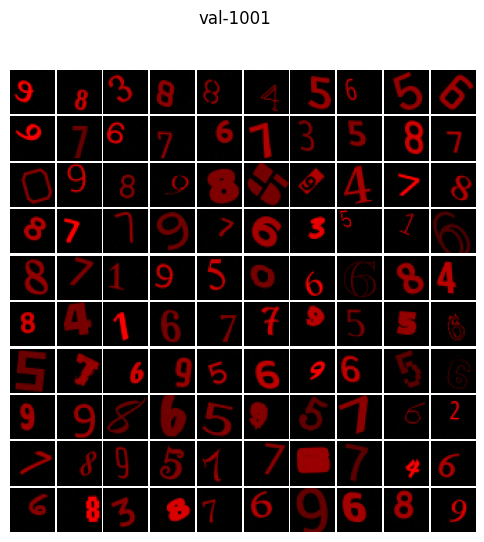

In [14]:
import numpy as np
t = Normalize([-1] *3, [2] *3)
rutas = [6,51,101,201,501,1001]
for i in rutas:
    ruta = f'models/scnn_synmnist_0.875_nobg_nobs_nofrz_{i}_cmnist_baseline.pth'
    # Load model to evaluate
    weights = torch.load(ruta)
    model.load_state_dict(weights)
    
    rs = get_representations(model, x)
    # Get train eigenvectors
    U, S, V = torch.pca_lowrank(rs['train'], center=True, q=1000)
    reps, indices = split_representations(rs)
    logits = get_logits(reps, V)
    
    for split in ['train','val']:
        images = []
        for c in [0,1]:
            indices_temp = torch.where(logits[split][c][:,0] <= 0)[0]
            images.append(t(x[split][indices[split][c]][indices_temp]))

        images = torch.concat(images)

        fig = plot_images_grid(images, 100)
        fig.suptitle(f'{split}-{i}')

### Ablation: Modulating the strength of the spurious correlation

In [48]:
# Give a set of directions to eliminate get acc on train_val
import numpy as np
import pandas as pd
temp_logits = dict()
mask = torch.ones_like(V)
#indices = [3]
#mask[:,indices] = 0 # Turn off selected indices
''''''

#f_V = V[mask.bool()].view(-1, 1000-len(indices))
f_V = V.clone()

p_inv = torch.linalg.pinv(f_V)
temp_reps = dict()

rutas = [
    f"models/scnn_synmnist_0.5_{bg}_nobs_cmnist_baseline.pth",
    f"models/scnn_synmnist_0.625_{bg}_nobs_cmnist_baseline.pth",
    f"models/scnn_synmnist_0.75_{bg}_nobs_cmnist_baseline.pth",
    f"models/scnn_synmnist_0.875_{bg}_nobs_cmnist_baseline.pth",
    f"models/scnn_synmnist_0.95_{bg}_nobs_cmnist_baseline.pth",
    f"models/scnn_synmnist_1_{bg}_nobs_cmnist_baseline.pth"
]
df = pd.DataFrame(columns=['Lambda', 'Train', 'Val', 'Test'])
for l in np.arange(0,1.1,0.1):
    with torch.no_grad():
        line = {'Lambda': [l]}
        for split in ['train','val','test']:
            model(x[split])
            temp_reps[split] = model.output
      
        for split in ['train','val','test']:
            temp_logits[split] = torch.matmul(temp_reps[split], f_V)  # Project to k most important directions
            temp_logits[split][:,0]*= l
            temp_logits[split] = torch.matmul(temp_logits[split],p_inv)
            temp_logits[split] += reps_mean
            temp_logits[split] = model.fc(temp_logits[split])             # Pass through classifier for result
            # Create a new row and append it to the DataFrame
            line[split.capitalize()] = [mean_accuracy(temp_logits[split],y[split]).item()]
        
        new_row = pd.DataFrame(line)
        df = pd.concat([df, new_row], ignore_index=True)
            


In [49]:
# Set the desired format
pd.options.display.float_format = '{:.3f}'.format
df['Lambda'] = df['Lambda'].map(lambda x: '{:.1f}'.format(x))
df

Lambda  Train   Val  Test
0     0.0  0.740 0.873 0.874
1     0.1  0.781 0.865 0.865
2     0.2  0.820 0.856 0.856
3     0.3  0.854 0.840 0.842
4     0.4  0.884 0.822 0.822
5     0.5  0.906 0.799 0.800
6     0.6  0.923 0.770 0.772
7     0.7  0.936 0.736 0.743
8     0.8  0.941 0.701 0.710
9     0.9  0.943 0.663 0.667
10    1.0  0.941 0.621 0.626

## Baselines Magnitude, Gradient Sign

In [2]:
def evaluate(model, x, y):
    with torch.no_grad():
        logits = model(x)
        return mean_accuracy(logits, y)
    
    
def magnitude_selection(mask, tensors, ratio):
    tensors = deepcopy(tensors)
    combined_mask = torch.cat([mask_tensor.flatten() for mask_tensor in mask.values()]).cpu()
    combined_tensors = torch.cat([tensor.flatten() for tensor in tensors.values()]).cpu()
    #comb_tens_zeros = torch.zeros_like(combined_tensors)
    magnitudes = torch.abs(combined_tensors) * combined_mask.float()
    nonzero_mask = magnitudes != 0
    magnitudes[magnitudes == 0] = 10000
    # Get the magnitudes of the selected non-zero values

    # Get the number of values to select based on the given percentage and the count of non-zero values in the combined mask
    num_values = int(torch.sum(nonzero_mask) * (ratio))

    # Get the indices of the non-zero values with the smallest magnitudes
    sorted_indices = torch.argsort(magnitudes, descending=False)

    # Create a new mask with the selected values
    new_combined_mask = torch.zeros_like(combined_mask)
    new_combined_mask[nonzero_mask] = 1
    new_combined_mask[sorted_indices[num_values:]] = 0

    # Reshape the new mask to match the shape of the combined mask
    #new_combined_mask = new_combined_mask.reshape(combined_mask.shape)

    # Split the new mask into individual masks for each dictionary
    new_mask = {}
    index = 0
    for key in mask.keys():
        num_elements = mask[key].numel()
        new_mask[key] = new_combined_mask[index:index+num_elements].reshape(mask[key].shape)
        index += num_elements

    return new_mask

### Magnitude Pruning (Zero, Reinitialize weights)

In [66]:
from masks import forget_model, generate_mask_percentile_partial, generate_mask_percentile_full, generate_mask
from copy import deepcopy
baseline_results =  defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for method in ['reinitialize', 'zero']:
    for asc in [True, False]:
        for ratio in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            accs = dict()
            model.load_state_dict(old_weights)
            mask = generate_mask_percentile_full(old_weights, ratio, asc=asc)
            model = forget_model(args,model, mask, forget_method=method)

            accs['train'] = float(evaluate(model, x['train'], y['train']))
            accs['test'] = float(evaluate(model, x['val'], y['val']))
            baseline_results[method][asc][ratio] = deepcopy(accs)

Forgetting: 1.00% of weights
Forgetting: 10.00% of weights
Forgetting: 20.00% of weights
Forgetting: 30.00% of weights
Forgetting: 40.00% of weights
Forgetting: 50.00% of weights
Forgetting: 60.00% of weights
Forgetting: 70.00% of weights
Forgetting: 80.00% of weights
Forgetting: 90.00% of weights
Forgetting: 1.00% of weights
Forgetting: 10.00% of weights
Forgetting: 20.00% of weights
Forgetting: 30.00% of weights
Forgetting: 40.00% of weights
Forgetting: 50.00% of weights
Forgetting: 60.00% of weights
Forgetting: 70.00% of weights
Forgetting: 80.00% of weights
Forgetting: 90.00% of weights
Forgetting: 1.00% of weights
Forgetting: 10.00% of weights
Forgetting: 20.00% of weights
Forgetting: 30.00% of weights
Forgetting: 40.00% of weights
Forgetting: 50.00% of weights
Forgetting: 60.00% of weights
Forgetting: 70.00% of weights
Forgetting: 80.00% of weights
Forgetting: 90.00% of weights
Forgetting: 1.00% of weights
Forgetting: 10.00% of weights
Forgetting: 20.00% of weights
Forgetting: 30

In [67]:
import pandas as pd

# Assuming baseline_results is the nested defaultdict
# Convert the defaultdict to a regular dictionary
baseline_results_dict = dict(baseline_results)

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame.from_dict({(method, asc, ratio): values for method, inner_dict in baseline_results_dict.items()
                             for asc, inner_dict2 in inner_dict.items()
                             for ratio, values in inner_dict2.items()}, orient='index')

# Reset the index and rename the columns
df.reset_index(inplace=True)
df.rename(columns={'level_0': 'Method', 'level_1': 'asc', 'level_2': 'ratio'}, inplace=True)

# Print the DataFrame
print(df)
# Use pivot_table to expand the table
from IPython.display import display, Latex
pivot_table = df.pivot_table(index="ratio", columns=["Method", "asc"], values=["test","train"], aggfunc="first")
late =df.to_latex()
print(late)

          Method    asc  ratio     train     test
0   reinitialize   True   0.01  0.679775  0.76260
1   reinitialize   True   0.10  0.826775  0.23135
2   reinitialize   True   0.20  0.470187  0.57475
3   reinitialize   True   0.30  0.487750  0.53205
4   reinitialize   True   0.40  0.405050  0.61730
5   reinitialize   True   0.50  0.495912  0.51450
6   reinitialize   True   0.60  0.502988  0.50025
7   reinitialize   True   0.70  0.503475  0.51455
8   reinitialize   True   0.80  0.534525  0.50085
9   reinitialize   True   0.90  0.448025  0.53390
10  reinitialize  False   0.01  0.570800  0.52030
11  reinitialize  False   0.10  0.499512  0.50130
12  reinitialize  False   0.20  0.464750  0.54895
13  reinitialize  False   0.30  0.485738  0.50550
14  reinitialize  False   0.40  0.500600  0.49840
15  reinitialize  False   0.50  0.649800  0.32830
16  reinitialize  False   0.60  0.500475  0.49870
17  reinitialize  False   0.70  0.500462  0.49870
18  reinitialize  False   0.80  0.569188  0.42750


### Focus on same/different sign gradients

In [62]:
from copy import deepcopy

from masks import forget_model, generate_mask, add_masks, generate_random_mask, generate_mask_percentile_full, generate_sign_mask
baseline_results =  defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
for method in ['reinitialize','zero']:
    for asc in [True,False]:
        for ratio in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            print(ratio)
            accs = dict()
            model.load_state_dict(old_weights)
            mask = generate_mask(input_for_mask, method='spur_grads', t=0.1, asc=asc)
            # keep ratio weights that are not on the mask
            mask = magnitude_selection(mask, old_weights ,ratio)
            model = forget_model(args, model, mask, forget_method=method)
            accs['train'] = float(evaluate(model, x['train'], y['train']))
            accs['test'] = float(evaluate(model, x['val'], y['val']))
            baseline_results[method][asc][ratio] = deepcopy(accs)

0.01
Forgetting: 0.81% of weights
0.1
Forgetting: 8.13% of weights
0.2
Forgetting: 16.26% of weights
0.3
Forgetting: 24.38% of weights
0.4
Forgetting: 32.51% of weights
0.5
Forgetting: 40.64% of weights
0.6
Forgetting: 48.77% of weights
0.7
Forgetting: 56.90% of weights
0.8
Forgetting: 65.02% of weights
0.9
Forgetting: 73.15% of weights
0.01
Forgetting: 0.36% of weights
0.1
Forgetting: 3.60% of weights
0.2
Forgetting: 7.20% of weights
0.3
Forgetting: 10.80% of weights
0.4
Forgetting: 14.39% of weights
0.5
Forgetting: 17.99% of weights
0.6
Forgetting: 21.59% of weights
0.7
Forgetting: 25.19% of weights
0.8
Forgetting: 28.79% of weights
0.9
Forgetting: 32.39% of weights
0.01
Forgetting: 0.81% of weights
0.1
Forgetting: 8.13% of weights
0.2
Forgetting: 16.26% of weights
0.3
Forgetting: 24.38% of weights
0.4
Forgetting: 32.51% of weights
0.5
Forgetting: 40.64% of weights
0.6
Forgetting: 48.77% of weights
0.7
Forgetting: 56.90% of weights
0.8
Forgetting: 65.02% of weights
0.9
Forgetting: 73

tensor([1, 3, 4, 5])
tensor([], dtype=torch.int64)
{'mask1': tensor([[ True, False,  True],
        [ True,  True, False]]), 'mask2': tensor([[False, False, False],
        [False, False, False]])}


In [65]:
import pandas as pd

# Assuming baseline_results is the nested defaultdict
# Convert the defaultdict to a regular dictionary
baseline_results_dict = dict(baseline_results)

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame.from_dict({(method, asc, ratio): values for method, inner_dict in baseline_results_dict.items()
                             for asc, inner_dict2 in inner_dict.items()
                             for ratio, values in inner_dict2.items()}, orient='index')

# Reset the index and rename the columns
df.reset_index(inplace=True)
df.rename(columns={'level_0': 'Method', 'level_1': 'asc', 'level_2': 'ratio'}, inplace=True)

# Print the DataFrame
print(df)
# Use pivot_table to expand the table
from IPython.display import display, Latex
pivot_table = df.pivot_table(index="ratio", columns=["Method", "asc"], values=["test","train"], aggfunc="first")

print(pivot_table)
late =df.to_latex()
print(late)

          Method    asc  ratio     train     test
0   reinitialize   True   0.01  0.728625  0.60585
1   reinitialize   True   0.10  0.659863  0.41490
2   reinitialize   True   0.20  0.316287  0.73850
3   reinitialize   True   0.30  0.531337  0.53405
4   reinitialize   True   0.40  0.562450  0.48135
5   reinitialize   True   0.50  0.555062  0.50645
6   reinitialize   True   0.60  0.397800  0.65965
7   reinitialize   True   0.70  0.270200  0.74070
8   reinitialize   True   0.80  0.485725  0.52925
9   reinitialize   True   0.90  0.425875  0.58800
10  reinitialize  False   0.01  0.919513  0.69220
11  reinitialize  False   0.10  0.895712  0.55165
12  reinitialize  False   0.20  0.603025  0.65450
13  reinitialize  False   0.30  0.460512  0.80025
14  reinitialize  False   0.40  0.865875  0.40615
15  reinitialize  False   0.50  0.558487  0.45425
16  reinitialize  False   0.60  0.638788  0.58180
17  reinitialize  False   0.70  0.610187  0.63815
18  reinitialize  False   0.80  0.698650  0.53525


In [8]:
# Use pivot_table to expand the table
from IPython.display import display, Latex

pivot_table = df.pivot_table( columns=["Method", "asc"], values=["test","train"], aggfunc="first")

late =pivot_table.to_latex()

print(late)
display(Latex(late))

\begin{tabular}{lrrrr}
\toprule
Method & \multicolumn{2}{r}{reinitialize} & \multicolumn{2}{r}{zero} \\
asc & False & True & False & True \\
\midrule
test & 0.457400 & 0.468050 & 0.501300 & 0.638800 \\
train & 0.560838 & 0.534550 & 0.499525 & 0.407300 \\
\bottomrule
\end{tabular}



<IPython.core.display.Latex object>

## Camelyon17


In [1]:
import torch
from models import simplecnn, densenet
from dataset import get_spurious_samples, make_dataloaders
from easydict import EasyDict  as edict
from torchvision.transforms import ToTensor, Normalize, Compose
from collections import defaultdict
from train import get_gradients_from_data
from copy import deepcopy


def mean_accuracy(logits, y):
    preds = (logits.squeeze() > 0.).float()
    return  ((preds - y).abs() < 1e-2).float().mean()

task_args = edict()
args = edict()
args.eval_datasets = dict()
task_args.mode = ["task"
                   #, 'play'
                  # ,'forget'
                   ]
args.dataset_paths = {'synmnist': "SynMNIST", "camelyon": "../datasets"}
task_args.dataset = {'name': 'camelyon', 'splits': ['id_val'], 'bs': 32}
splits = ['id_val','val','test']
args.eval_datasets['task'] = {'name': 'camelyon', 'splits': splits, 'bs': 1024}

args.model='densenet'
for k,v in task_args.items():
    args['task_'+k] = v
    
args.task_args = task_args

dls = make_dataloaders(args)

x = defaultdict(list)
y = defaultdict(list)

'''for split in ['id_val', 'val']:
    for xs,ys  in dls['eval']['task'][split]:
        x[split].append(xs)
        y[split].append(ys)
        
    x[split] = torch.cat(x[split])
    y[split] = torch.cat(y[split])
'''

# Cargar modelo preentrenado
#ruta = "models/scnn_synmnist_0.875_nobg_nobs_nofrz_1001_cmnist_baseline.pth"
#ruta = "models/scnn_synmnist_0.875_nobg_nobs_nofrz_101_cmnist_baseline.pth"
#weights = torch.load(ruta)
#old_weights = weights

#model = simplecnn(args)
#model.load_state_dict(weights)
#model = model

"for split in ['id_val', 'val']:\n    for xs,ys  in dls['eval']['task'][split]:\n        x[split].append(xs)\n        y[split].append(ys)\n        \n    x[split] = torch.cat(x[split])\n    y[split] = torch.cat(y[split])\n"

In [185]:

from train import evaluate
from models import simplecnn, densenet
# Cargar modelo preentrenado
ruta = "models/densenet_None_nofrz_22001_111_.pth"
weights = torch.load(ruta)
old_weights = weights

model = densenet(args)
model.load_state_dict(weights)
model = model

# Registrar hook para obtener valores intermedios
def hook_fn(module, input, output):
    out = F.relu(output, inplace=True)
    out = F.adaptive_avg_pool2d(out, (1, 1))
    out = torch.flatten(out, 1)
    model.output = out

#print(dir(model))
model.features.register_forward_hook(hook_fn)

In [186]:
# Evaluate model on splits
model = model.cuda()
results = dict()
for split in splits:
    results[split] = evaluate(model, dls['eval']['task'][split], caption=split)
    
model = model.cpu()

[TEST       ] [05208/85054 (6%)] Loss: 0.585 Acc: 75.55%5%

In [187]:
results

{'id_val': {'id_val_loss': 0.09715906530618668,
  'id_val_acc': 96.85041809082031},
 'val': {'val_loss': 0.33525240421295166, 'val_acc': 87.58021545410156},
 'test': {'test_loss': 0.58523029088974, 'test_acc': 75.5461196899414}}

In [188]:
%%time
import torch.nn.functional as F
reps = defaultdict(list)
splits = ['id_val','val','test']
model = model.cuda()
model.eval()


y = defaultdict(list)
for split in splits:
    print(split)
    with torch.no_grad():
        for xs,ys  in dls['eval']['task'][split]:
            model(xs.cuda())
            reps[split].append(model.output.clone().detach().cpu())
        
            y[split].append(ys)
        
        reps[split] = torch.concat(reps[split])
      #  bs, *_ = reps[split].shape
      #  reps[split] = F.adaptive_avg_pool2d(reps[split], (1, 1))
      #  reps[split] = reps[split].view(bs, -1)
        y[split] = torch.concat(y[split])
        


id_val
val
test
CPU times: user 2min 12s, sys: 6.25 s, total: 2min 19s
Wall time: 2min 18s


In [189]:
model = model.cuda()
split_accs = dict()
for split in ['id_val','val','test']:
    logits = model.classifier(reps[split].cuda()) 
    split_accs[split] = mean_accuracy(logits, y[split].cuda())


In [190]:

least=True
weights = torch.load(ruta)
old_weights = weights
model.load_state_dict(weights)



#for split in splits:
#    logits = model(x[split])
#    split_accs[split] = mean_accuracy(logits, y[split])

# calculate representations
# Get train eigenvectors
reps_train = reps['id_val'] - reps['id_val'].mean(dim=0)
reps_val = reps['val'] - reps['id_val'].mean(dim=0)
reps_test = reps['test'] - reps['id_val'].mean(dim=0)
U, S, V = torch.pca_lowrank(reps['id_val'], center=True, q=1000)
y_test = y['val']



In [195]:
from tqdm.notebook import tqdm
accs = defaultdict(list)
model = model.cpu()
least = False
iterations = list(range(10))

model.load_state_dict(weights)
model.eval()

iterations = [1,2,3,4,5,50,100,500]
for k in tqdm(iterations):
    V_selected = V[:,:k]

    with torch.no_grad():
        p_inv = torch.linalg.pinv(V_selected)                # Calculate pseudoinverse...
        print(p_inv.shape)
        logits_train = torch.matmul(reps_train, V_selected)  # Project to k more important directions
        #ogits_train[:,k]*= 0
        logits_train = torch.matmul(logits_train, p_inv)  # Come back to original space via pseudoinverse
        logits_train += reps_train.mean(dim=0)            # Add back the mean from training data to predict
        logits_train = model.classifier(logits_train)             # Pass through classifier for result

        accs['id_val'].append(mean_accuracy(logits_train,y['id_val']))

        logits_val = torch.matmul(reps_val, V_selected)      # Project to k more important directions
        #logits_val[:,k]*= 0
        logits_val = torch.matmul(logits_val, p_inv)      # Come back to original space via pseudoinverse
        logits_val += reps_train.mean(dim=0)              # Add back the mean from training data to predict
        logits_val = model.classifier(logits_val)                 # Pass through classifier for result

        accs['val'].append(mean_accuracy(logits_val,y['val']))
        
        logits_test = torch.matmul(reps_test, V_selected)      # Project to k more important directions
        #logits_test[:,k]*= 0
        logits_test = torch.matmul(logits_test, p_inv)      # Come back to original space via pseudoinverse
        logits_test += reps_train.mean(dim=0)              # Add back the mean from training data to predict
        logits_test = model.classifier(logits_test)                 # Pass through classifier for result

        accs['test'].append(mean_accuracy(logits_test,y['test']))

  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([1, 1024])
torch.Size([2, 1024])
torch.Size([3, 1024])
torch.Size([4, 1024])
torch.Size([5, 1024])
torch.Size([50, 1024])
torch.Size([100, 1024])
torch.Size([500, 1024])


In [156]:
def create_results_plot(results, accuracies,  caption="Acc (%) vs losing Top K directions"):
    
    def create_plot(ax, accs, split_accs, iterations):
        ax.set_title(f"{caption}")
        ax.plot(iterations, accs['id_val'][:n], label='train data', color='red')
        ax.plot(iterations, accs['val'][:n], label='val data', color='blue')
        ax.axhline(y=split_accs['val'], color='blue', linestyle='--', label="full val")
        ax.axhline(y=split_accs['id_val'], color='red', linestyle='--', label='full train')
        ax.plot(iterations, accs['test'][:n], label='test data', color='green')
        ax.axhline(y=split_accs['test'], color='green', linestyle='--', label="full test")
        ax.legend()
    
    fig, axs = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(16, 5)

   # for i, (split, accs) in enumerate(results.items()):
    n = 100
    create_plot(axs[0],  accs, accuracies, iterations[:n])
    create_plot(axs[1],  accs, accuracies, iterations[:n])

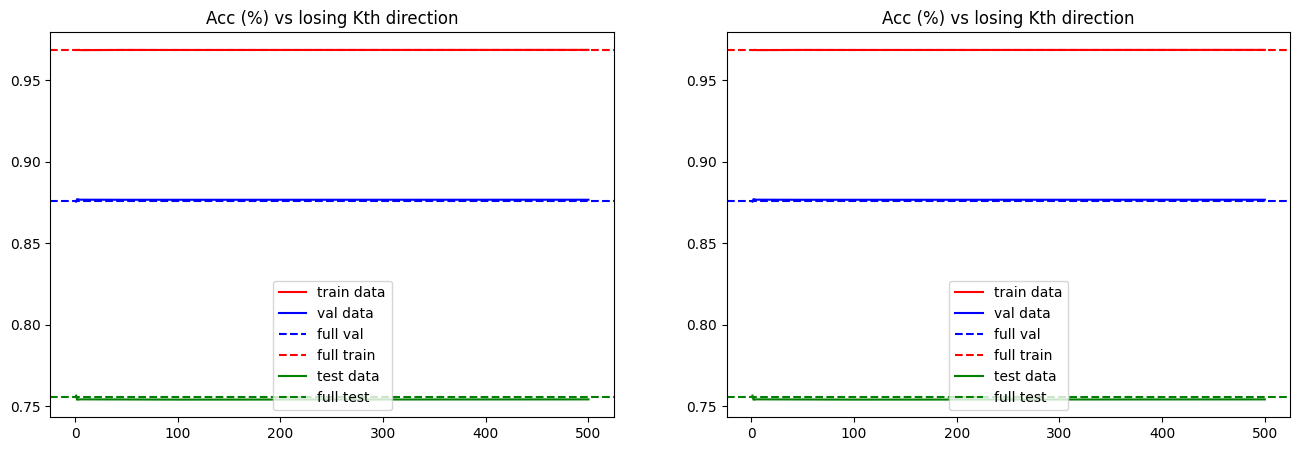

In [196]:
create_results_plot(accs, {k:v.cpu() for k,v in  split_accs.items()},  caption="Acc (%) vs losing Kth direction")

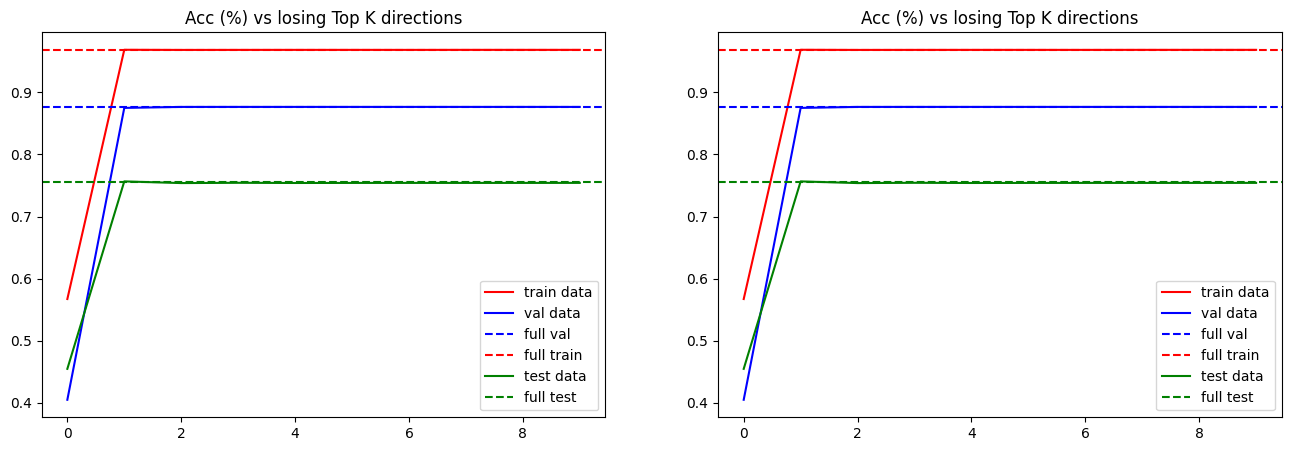

In [129]:
create_results_plot(accs, split_accs,  caption="Acc (%) vs losing Top K directions")

KeyError: 'val'

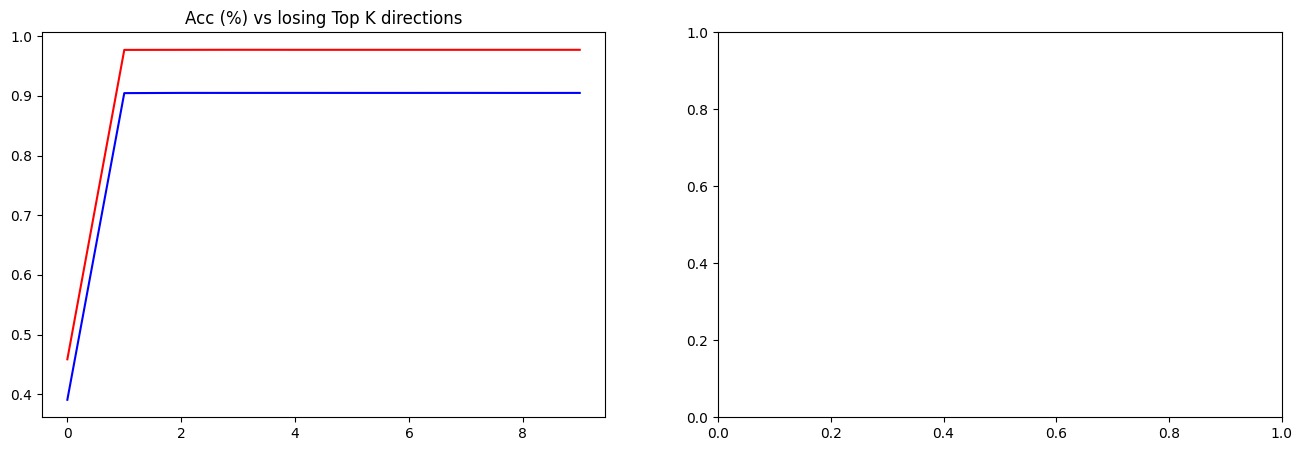

In [134]:
create_results_plot(accs, split_accs,  caption="Acc (%) vs losing Top K directions")

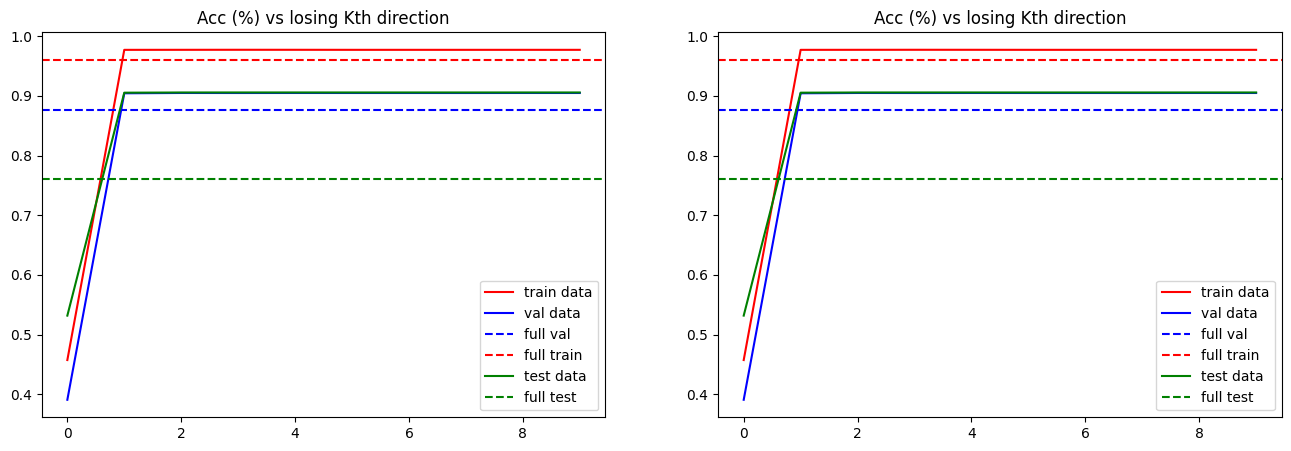

In [152]:
create_results_plot(accs, split_accs,  caption="Acc (%) vs losing Kth direction")

In [151]:
split_accs = {'id_val': 0.96, 'val': 0.8755, 'test': 0.76}

In [199]:
for s in S:
    print(s)

tensor(373.7960)
tensor(93.2746)
tensor(41.5249)
tensor(34.5082)
tensor(28.2641)
tensor(17.9547)
tensor(17.4706)
tensor(15.8121)
tensor(12.5469)
tensor(12.4017)
tensor(11.9160)
tensor(11.7468)
tensor(9.9015)
tensor(9.0602)
tensor(8.5402)
tensor(8.2533)
tensor(7.5819)
tensor(7.2234)
tensor(7.1914)
tensor(6.9099)
tensor(6.0998)
tensor(5.9502)
tensor(5.5736)
tensor(5.2795)
tensor(5.2156)
tensor(4.9773)
tensor(4.7313)
tensor(4.4389)
tensor(4.2177)
tensor(4.1387)
tensor(4.0347)
tensor(3.9079)
tensor(3.8288)
tensor(3.8063)
tensor(3.6537)
tensor(3.5766)
tensor(3.5193)
tensor(3.4325)
tensor(3.3640)
tensor(3.3121)
tensor(3.1696)
tensor(3.1556)
tensor(3.1010)
tensor(3.0288)
tensor(2.9683)
tensor(2.9494)
tensor(2.8867)
tensor(2.8325)
tensor(2.7819)
tensor(2.7259)
tensor(2.7022)
tensor(2.6348)
tensor(2.5752)
tensor(2.4968)
tensor(2.4495)
tensor(2.4284)
tensor(2.3997)
tensor(2.3923)
tensor(2.3267)
tensor(2.2937)
tensor(2.2555)
tensor(2.2408)
tensor(2.2121)
tensor(2.1553)
tensor(2.1195)
tensor(2.084

In [175]:
split_accs

{'id_val': tensor(0.9685, device='cuda:0'),
 'val': tensor(0.8758, device='cuda:0'),
 'test': tensor(0.7555, device='cuda:0')}

In [197]:
accs

defaultdict(list,
            {'id_val': [tensor(0.9684),
              tensor(0.9683),
              tensor(0.9684),
              tensor(0.9684),
              tensor(0.9683),
              tensor(0.9684),
              tensor(0.9684),
              tensor(0.9684)],
             'val': [tensor(0.8754),
              tensor(0.8769),
              tensor(0.8768),
              tensor(0.8767),
              tensor(0.8766),
              tensor(0.8765),
              tensor(0.8765),
              tensor(0.8766)],
             'test': [tensor(0.7565),
              tensor(0.7539),
              tensor(0.7543),
              tensor(0.7541),
              tensor(0.7542),
              tensor(0.7541),
              tensor(0.7540),
              tensor(0.7542)]})